# Estadificación de Alzheimer por medio de imágenes MRI utilizando redes neuronales

Dataset provisto por el sitio web de Kaggle: https://www.kaggle.com/tourist55/Alzheimers-dataset-4-class-of-images

Probamos el modelo sin un pre-procesamiento demasiado fino


In [1]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9632 sha256=00d290b4edcf7e4387f4d9af0252b2c98afe5dd7cc2336a08c94c4b78fa59f81
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


Accedemos a nuestro drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset')

In [4]:
!ls

checkpoint  loss_plot.png  TensorFlow.ipynb  test  train  Untitled0.ipynb


In [5]:
!ls test

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [6]:
!ls train

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


# Importamos librerías necesarias

In [7]:
# Generales
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Data
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

# Model
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# from pytorchtools import EarlyStopping

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# Config

In [13]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Cargar datos

In [9]:
FOLDER_PATH = 'train'
categories = sorted(os.listdir(FOLDER_PATH))
num_classes = 4

MILD_INDEX = categories.index("MildDemented")
MODERATE_INDEX = categories.index("ModerateDemented")
NON_INDEX = categories.index("NonDemented")
VERYMILD_INDEX = categories.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path = [list() for category in categories]

for index, category in enumerate(categories):
    category_path = os.path.join(FOLDER_PATH, category)

    # Recorrer imágenes
    images = [i for i in os.listdir(category_path)]
    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        images_path[index].append(image_path)

print("Sobre el dataset")
for category_name, images in zip(categories, images_path):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 717
#Imagenes de la clase ModerateDemented: 52
#Imagenes de la clase NonDemented: 2560
#Imagenes de la clase VeryMildDemented: 1792


In [10]:
train_data = list()

for class_index, images_per_class in enumerate(images_path):
  train_data.extend([(img, class_index) for img in images_per_class])

In [11]:
FOLDER_PATH_TEST = 'test'
categories_test = sorted(os.listdir(FOLDER_PATH_TEST))
num_classes = 4

MILD_INDEX_TEST = categories_test.index("MildDemented")
MODERATE_INDEX_TEST = categories_test.index("ModerateDemented")
NON_INDEX_TEST = categories_test.index("NonDemented")
VERYMILD_INDEX_TEST = categories_test.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path_test = [list() for category in categories_test]

for index, category in enumerate(categories_test):
    category_path_test = os.path.join(FOLDER_PATH_TEST, category)

    # Recorrer imágenes
    images_test = [i for i in os.listdir(category_path_test)]
    for image_name in images_test:
        image_path_test = os.path.join(category_path_test, image_name)
        images_path_test[index].append(image_path_test)

print("Sobre el dataset")
for category_name, images in zip(categories_test, images_path_test):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 179
#Imagenes de la clase ModerateDemented: 12
#Imagenes de la clase NonDemented: 640
#Imagenes de la clase VeryMildDemented: 448


In [12]:
test_data = list()

for class_index, images_per_class in enumerate(images_path_test):
  test_data.extend([(img, class_index) for img in images_per_class])

* Las clases están muy desbalanceadas

## Visualización random

In [15]:
# random.seed(0)

def pick_randomly_file(image_list, ammount):
    max_length = len(image_list)
    chosen_images = []
    for _ in range(ammount):
        index = random.randint(0, max_length)
        chosen_images.append(image_list[index])
    
    return chosen_images


sample_images = 5
mild_sample = pick_randomly_file(images_path[MILD_INDEX], sample_images)
moderate_sample = pick_randomly_file(images_path[MODERATE_INDEX], sample_images)
non_sample = pick_randomly_file(images_path[NON_INDEX], sample_images)
Verymild_sample = pick_randomly_file(images_path[VERYMILD_INDEX], sample_images)


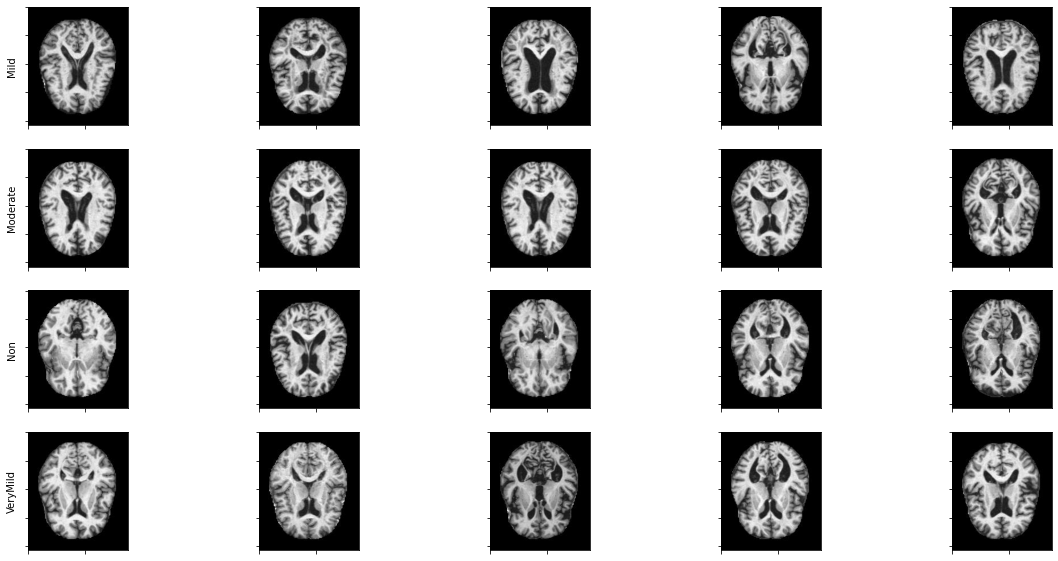

In [16]:
def visualize_sample(image_list, ax, title):
    ax[0].set_ylabel(title)
    for index in range(len(image_list)):        
        ax[index].imshow(cv2.imread(image_list[index]))
        ax[index].set_yticklabels([])
        ax[index].set_xticklabels([])


fx, ax = plt.subplots(num_classes,sample_images, figsize=(20,10))
visualize_sample(mild_sample, ax[0], "Mild")
visualize_sample(moderate_sample, ax[1], "Moderate")
visualize_sample(non_sample, ax[2], "Non")
visualize_sample(Verymild_sample, ax[3], "VeryMild")

plt.show()

In [17]:
img_sample = cv2.imread(train_data[0][0])

In [18]:
img_sample.shape

(208, 176, 3)

El conjunto de datos se encuentra desbalanceado, tiene imágenes de una dimensión de 208 x 176 x 3 dimensiones. 

# Clase DataSet

Pre-procesamiento planteado: 
* Resize
* Normalzación
* Mejoras a futuro: data augmentation para las clases minoritarias "Mild demented", "Moderate demented"

In [68]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):
  """
  Procesa todas las imágenes de interés para el entrenamiento y los devuelve de a batches con un dataloader
  """

  def __init__(self, raw_data, input_size=(224,224)):
        self.raw_data = raw_data
        self.input_size = input_size


  def __len__(self):
      return len(self.raw_data)

  def __getitem__(self, idx):
      label = self.raw_data[idx][1]
      target_tensor = torch.tensor(label).type(torch.LongTensor)
      #print(label)
      img_path = self.raw_data[idx][0]
      image = cv2.imread(img_path)
      image = cv2.resize(image, self.input_size)
      image = image / 255.

      input_tensor = torch.from_numpy(image).reshape(3,self.input_size[0], self.input_size[1]).float()
      # print(input_tensor.dtype)

      return input_tensor, target_tensor

# Creamos la red neuronal

Siguiendo la bibliografía, hacemos uso de la técnica de transfer learning llamando a una red neuronal pre-entrenada aprovechando sus pesos como inicializadores del nuevo modelo que queremos armar. Modificamos la capa de clasificación para nuestra tarea.

In [55]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

model = models.resnet50(pretrained=True)
backbone_out = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(backbone_out,256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256,4),
    nn.LogSoftmax(dim=1)
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Definimos algunos hiperparámetros

In [56]:
# Hyperparameters
lr = 0.0001              # Learning rate
input_size = (224,224)

# Select the device to use
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Send the model to the device
model = model.to(device)

# Create dataloader
from torch.utils.data import DataLoader

batch_size = 50

In [57]:
from torchsummary import summary

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [58]:
dataset = MRIDataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Definimos algunos pesos para agregar a la función de pérdida, para que el modelo penalice más aquellas pérdidas que se dan en las clases minoritarias
En teoría los pesos serían fijados de la forma:
* wj=n_samples / (n_classes * n_samplesj)

Donde:  
n_samples = cantidad de muestras en el conjunto  
n_classes = número de clases 'Target'  
n_samplesj = cantidad de muestras para la clase especificada  

En nuestro caso tenemos una clase minoritaria que tiene una frecuencia muy pequeña, lo que daría como resultado del cálculo, un número muy grande. Esto podría llevar a que el modelo se inclince por esta clase y hasta pueda producir errores, por lo que se escala el resultado para no tener este tipo de problemas

In [59]:
import torch.optim as optim


# Create an optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

n_samples = len(train_data)
n_classes = len(categories)

w1 = (n_samples/(n_classes*717)) - 0.5
w2 =(( n_samples/(n_classes*52)) * 0.10 )- 0.5
w3 = n_samples/(n_classes*2560)
w4 = n_samples/(n_classes*1792)

weight = torch.tensor([w1,w2,w3,w4])

weight = weight.to(device)

# Loss Function
criterion = nn.NLLLoss(weight= weight)

# Entrenamiento

In [60]:
import sys
from progress.bar import Bar

def train_model(new_model, train_data, criterion, optimizer, num_epochs=25):
    new_model.train()
    Bar.check_tty = False
    Bar.file = sys.stdout

    for epoch in range(num_epochs):

        total_loss = 0.0
        processed = 0
        bar = Bar('Training Model', max=len(dataloader))
        for index, (X,y) in enumerate(dataloader):
            input_tensor = X
            gt_tensor = y

            input_tensor = input_tensor.to(device)
            gt_tensor = gt_tensor.to(device)

            optimizer.zero_grad()
            output = new_model(input_tensor)
            loss = criterion(output, gt_tensor)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            processed += input_tensor.shape[0]
            Bar.suffix = 'Train: [{0}][{1}/{2}]|Tot: {total:} |ETA: {eta:} '.format(epoch+1, processed, len(train_data),total=bar.elapsed_td, eta=bar.eta_td)
            Bar.suffix = Bar.suffix + '| Loss {:.4f} '.format(total_loss / (index + 1))
            bar.next()
        bar.finish()
    return new_model

In [61]:
model = train_model(model, train_data, criterion, optimizer, num_epochs = 5)

Training Model |################################| Train: [1][5121/5121]|Tot: 0:01:04 |ETA: 0:00:01 | Loss 0.8406 
Training Model |################################| Train: [2][5121/5121]|Tot: 0:01:05 |ETA: 0:00:01 | Loss 0.1976 
Training Model |################################| Train: [3][5121/5121]|Tot: 0:01:04 |ETA: 0:00:01 | Loss 0.1115 
Training Model |################################| Train: [4][5121/5121]|Tot: 0:01:04 |ETA: 0:00:01 | Loss 0.0492 
Training Model |################################| Train: [5][5121/5121]|Tot: 0:01:05 |ETA: 0:00:01 | Loss 0.0269 


# Pre procesamos datos nuevos

In [65]:
def preprocess(path_to_image, label):
    img = cv2.imread(path_to_image)
    img = cv2.resize(img, input_size)    
    img = img / 255.
    input_tensor = torch.from_numpy(img).reshape(1, 3, input_size[0],input_size[1]).float()
    gt_tensor = torch.tensor([label]).type(torch.LongTensor)
    return input_tensor, gt_tensor

In [66]:
def test_model(new_model, test_data):

    y_true = []
    y_pred = []
    new_model = new_model.eval()
    Bar.check_tty = False
    Bar.file = sys.stdout
    bar = Bar('Testing Model', max=len(test_data))

    stats = [0 for _ in categories]
    total_items = [0 for _ in categories]
    for index, input_data in enumerate(test_data):
        img_path, target_class = input_data

        input_tensor, _ = preprocess(img_path, target_class)
        input_tensor = input_tensor.to(device)
        _ = _.to(device)
        output = new_model(input_tensor)
        loss = criterion(output, _)

        prediction = torch.argmax(output).item()
        
        y_pred.append(prediction)
        y_true.append(target_class)


        if target_class == prediction:
            stats[target_class] += 1
        total_items[target_class] += 1
        Bar.suffix = 'Test: [{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(index, len(test_data),total=bar.elapsed_td, eta=bar.eta_td)
        bar.next()
    
    bar.finish()
    for category_name, stat, tot in zip(categories, stats, total_items):
        acc = stat * 1.0 / tot
        print("Accuracy for class {}: {:.4f}".format(category_name, acc))

    print("\nReporte de clasificación: \n", classification_report(y_true, y_pred, target_names = categories))
    print("\nMatriz de confusión: \n")

    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels = categories, yticklabels = categories)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

Testing Model |################################| Test: [1278/1279]|Tot: 0:00:21 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.6034
Accuracy for class ModerateDemented: 0.2500
Accuracy for class NonDemented: 0.7859
Accuracy for class VeryMildDemented: 0.4531

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.39      0.60      0.47       179
ModerateDemented       0.75      0.25      0.38        12
     NonDemented       0.72      0.79      0.75       640
VeryMildDemented       0.68      0.45      0.54       448

        accuracy                           0.64      1279
       macro avg       0.63      0.52      0.54      1279
    weighted avg       0.66      0.64      0.64      1279


Matriz de confusión: 



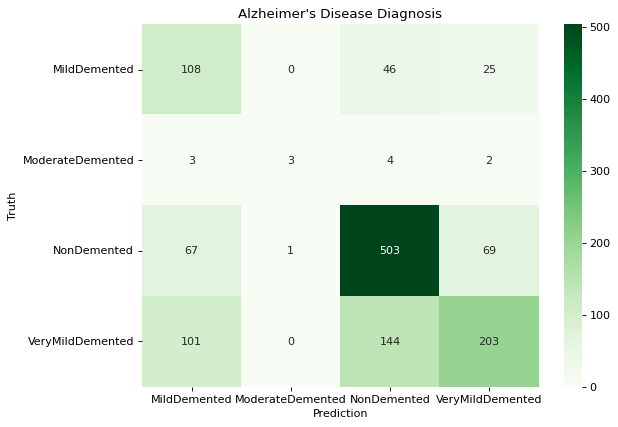

In [67]:
#test_model(model, train_data)
test_model(model, test_data)